# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Further Exploration](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction


Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, we will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. We will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. We will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions
 
1. How heavy is the service usage comparing weekday to weekend?
2. What's difference of the bike using pattern between the regular users and casual users?


<a id='wrangling'></a>
## Data Collection and Wrangling

In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly.  The data has already been collected in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed too. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 


In [55]:
## import all necessary packages and functions.
import csv 
from datetime import datetime 
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## Use the csv library to set up a DictReader object. ##
        trip_reader = csv.DictReader(f_in)
        
        ## Read the first trip from the data file and store it in a variable.     ##
        first_trip = next(trip_reader)
        
        ## Use the pprint library to print the first trip. ##
        pprint(first_trip)
       
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar


<a id='condensing'></a>
### Condensing the Trip Data

It's observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. We need trim and clean the data before exploration. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

We will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.




First, complete the helper functions to address each of the cleaning tasks described above.

In [57]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    """
    
    if city == 'Chicago' or city == 'NYC':
        duration = float(datum['tripduration']) / 60
    else:
        duration = float(datum['Duration (ms)']) / 60000
    
    return duration


# Some tests to check if code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# we printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [58]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.

    """
    
    if city == 'Chicago':
        dt = datetime.strptime(datum['starttime'], "%m/%d/%Y %H:%M")
    elif city == 'Washington':
        dt = datetime.strptime(datum['Start date'], "%m/%d/%Y %H:%M")
    else:
        dt = datetime.strptime(datum['starttime'], "%m/%d/%Y %H:%M:%S")
        
    month = int(dt.strftime('%m'))
    hour = int(dt.strftime('%H'))
    day_of_week = dt.strftime('%A')
        
    return (month, hour, day_of_week)


# Some tests to check if code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# we printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [59]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. Because Washington use 'Registered' for Subscriber, change it to Subscriber.
    """
    
    if city == 'Chicago' or city == 'NYC':
        user_type = datum['usertype']
    else: # else handle the case of Washington
        user_type = datum['Member Type']
        if user_type == 'Registered':
            user_type = 'Subscriber'
        else:
            user_type = 'Customer'

    return user_type


# Some tests to check if code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# we printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

Now, use the helper functions we wrote above to create a condensed data file for each city consisting only of the data fields indicated above. 

In [60]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            ## Use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            duration = duration_in_mins(row, city) 
            month, hour, day_of_week = time_of_trip(row, city) 
            user_type = type_of_user(row, city) 
            new_point['duration'] = duration
            new_point['month'] = month
            new_point['hour'] = hour
            new_point['day_of_week'] = day_of_week
            new_point['user_type'] = user_type
            
            
            ## Write the processed information to the output file.     ##
            trip_writer.writerow(new_point)
            
            

In [61]:
# Check the work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])



<a id='eda'></a>
## Exploratory Data Analysis

In this section we will compute descriptive statistics from the data. We will also use the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts.  

**Question**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?


In [62]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total)

In [63]:
city_files = {'Washington':'./data/Washington-2016-Summary.csv',
              'Chicago':'./data/Chicago-2016-Summary.csv',
              'NYC':'./data/NYC-2016-Summary.csv'}

# initialize the variables to record the maximum number of subscribers, customers and total along with the city
max_n_subscribers = 0
max_n_customers = 0
max_n_total = 0
    
for city, filename in city_files.items():
    # get the number of trips made by subscribers, customers, and total overall.
    n_subscribers, n_customers, n_total = number_of_trips(filename)
    
    # update the variables according to the returned value
    if max_n_subscribers < n_subscribers:
        max_n_subscribers = n_subscribers
        max_n_subscribers_city = city
    if max_n_customers < n_customers:
        max_n_customers = n_customers
        max_n_customers_city = city
    if max_n_total < n_total:
        max_n_total = n_total
        max_n_total_city = city
       
    
print("{} has the highest proportion of trips made by subscribers:{},\n \
       {} has the highest proportion of trips made by short-term customers:{},\n \
       {} has the highest total number of trips:{}".format(max_n_subscribers_city, 
                                                     max_n_subscribers,
                                                     max_n_customers_city,
                                                     max_n_customers,
                                                     max_n_total_city,
                                                     max_n_total))
                                                                                        



NYC has the highest proportion of trips made by subscribers:245896,
        NYC has the highest proportion of trips made by short-term customers:30902,
        NYC has the highest total number of trips:276798


**Answer**: NYC has the highest proportion of trips made by subscribers:245896,
            NYC has the highest proportion of trips made by short-term customers:30902,
            NYC has the highest number of trips:276798
            

Now, we will continue to investigate properties of the data.

**Question**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?


In [64]:
def length_of_trips(filename):
    """
    This function reads in a file with trip data and reports the average length of trips for each city 
    and the proportion of rides that's made in each city longer than 30 minutes.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        s_trip = 0
        s_trip_subscriber = 0
        s_trip_customer = 0
        n_trip_over_30min = 0
        n_trip = 0
        n_trip_subscriber = 0
        n_trip_customer = 0
        
        
        # tally up total trip duration according to the user type, total and duration.
        for row in reader:
            duration = float(row['duration'])
            s_trip += duration
            n_trip += 1
            if float(row['duration']) > 30:
                n_trip_over_30min += 1
            if row['user_type'] == 'Subscriber':
                s_trip_subscriber += duration
                n_trip_subscriber += 1
            else:
                s_trip_customer += duration
                n_trip_customer += 1
        
        avg_trip = s_trip/n_trip
        percent_over_30min = n_trip_over_30min / n_trip
        avg_trip_subscriber = s_trip_subscriber/ n_trip_subscriber
        avg_trip_customer = s_trip_customer / n_trip_customer
                
        # return tallies as a tuple
        return(avg_trip,percent_over_30min, avg_trip_subscriber, avg_trip_customer )

In [65]:

city_files = {'Washington':'./data/Washington-2016-Summary.csv',
              'Chicago':'./data/Chicago-2016-Summary.csv',
              'NYC':'./data/NYC-2016-Summary.csv'}

for city, filename in city_files.items():
    average_trip,percent_over_30min,average_trip_subscriber,average_trip_customer = length_of_trips(filename)
    print('{} has average trip duration of {} minutes, and its percentage of trip duration over 30 minutes is {:.0%}.'.format(city, int(average_trip), percent_over_30min))


Washington has average trip duration of 18 minutes, and its percentage of trip duration over 30 minutes is 11%.
Chicago has average trip duration of 16 minutes, and its percentage of trip duration over 30 minutes is 8%.
NYC has average trip duration of 15 minutes, and its percentage of trip duration over 30 minutes is 7%.


**Answer**: 
Washington has average trip duration of 18 minutes, and its percentage of trip duration over 30 minutes is 11%.
Chicago has average trip duration of 16 minutes, and its percentage of trip duration over 30 minutes is 8%.
NYC has average trip duration of 15 minutes, and its percentage of trip duration over 30 minutes is 7%.


**Question**: Dig deeper into the question of trip duration based on ridership. Which type of user takes longer rides on average: Subscribers or Customers?


In [66]:

for city, filename in city_files.items():
    average_trip,percent_over_30min,average_trip_subscriber,average_trip_customer = length_of_trips(filename)
    print('In {} the average trip duration of subscribers is {} minutes, and the average trip duration of customers is {} minutes.'.format(city, int(average_trip_subscriber), int(average_trip_customer)))



In Washington the average trip duration of subscribers is 12 minutes, and the average trip duration of customers is 41 minutes.
In Chicago the average trip duration of subscribers is 12 minutes, and the average trip duration of customers is 30 minutes.
In NYC the average trip duration of subscribers is 13 minutes, and the average trip duration of customers is 32 minutes.


**Answer**: Across the three citys, it's suprisingly consistent. In all three cities, cusotmers takes longer rides on average.
In Washington the average trip duration of subscribers is 12 minutes, and the average trip duration of customers is 41 minutes.
In Chicago the average trip duration of subscribers is 12 minutes, and the average trip duration of customers is 30 minutes.
In NYC the average trip duration of subscribers is 13 minutes, and the average trip duration of customers is 32 minutes.

<a id='visualizations'></a>
### Visualizations

While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. 

Select the city of Chicago to plot the distribution of trip times for the Subscribers and customers. 

In [67]:
def duration_of_trips(filename):
    """
    This function reads in a file with trip data and collect all the trip times/duration.
    """
    trip_times = []
    trip_times_subscriber = []
    trip_times_customer = []
    
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        #collect all the trip duration data in different user types
        for row in reader:
            trip_times.append(float(row['duration']))
            if row['user_type'] == 'Subscriber':
                trip_times_subscriber.append(float(row['duration']))
            else:
                trip_times_customer.append(float(row['duration']))
    
    return(trip_times, trip_times_subscriber, trip_times_customer)
        

In [68]:
# Collect all of the trip times as a list and then use pyplot functions to generate a histogram of trip times.
# load library

# choose Chicago data file for analysis and visualization
city_file = './data/Chicago-2016-Summary.csv'

#initialize the variable
city_trip_times = []

city_trip_times,trip_times_subscriber,trip_times_customer = duration_of_trips(city_file)



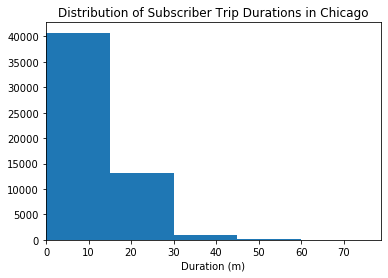

In [69]:

#plot the districut of trip times for subscribers in Chicago
#Add limits to the plots so that only trips of duration less than 75 minutes are plotted. 
#Set the plots up so that bars are in five-minute wide intervals.
plt.hist(trip_times_subscriber, 5, (0,75))
plt.title('Distribution of Subscriber Trip Durations in Chicago')
plt.xlabel('Duration (m)')
plt.xlim(xmin=0.0)
#plt.margins(x=0)
plt.show()


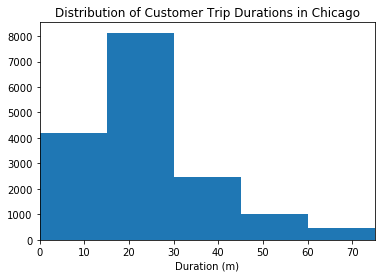

In [70]:
#plot the districut of trip times for subscribers in Chicago
plt.hist(trip_times_customer, 5, (0,75))
plt.title('Distribution of Customer Trip Durations in Chicago')
plt.xlabel('Duration (m)')
plt.margins(x=0)
plt.show()

According to the generated plot, it shows in Chicago the peak of subscribers trip duration is from 0 to 15 minutes. For customers, the peak of trip duration is from 15 to 30 minutes. The both distributions are righ-skewed. 

<a id='eda_continued'></a>
## Further Analysis
 

**Question:** Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?


In [71]:

def trip_duration_pattern(filename):
    """
    This function reads in a file with trip data and reports the average trip durations, 
    according to the rider type on weekdays vs weekends.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscriber_weekdays = 0
        n_customer_weekdays = 0
        n_subscriber_weekends = 0
        n_customer_weekends = 0
        s_subscriber_weekdays = 0
        s_customer_weekdays = 0
        s_subscriber_weekends = 0
        s_customer_weekends = 0
        
        weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

        # tally up the trip times according to the rider type and days in a week.
        for row in reader:
            if row['day_of_week'] in weekdays:
                if row['user_type'] == 'Subscriber':
                    n_subscriber_weekdays += 1
                    s_subscriber_weekdays += float(row['duration'])
                else:
                    n_customer_weekdays += 1
                    s_customer_weekdays += float(row['duration'])
            else:
                if row['user_type'] == 'Subscriber':
                    n_subscriber_weekends += 1
                    s_subscriber_weekends += float(row['duration'])
                else:
                    n_customer_weekends += 1
                    s_customer_weekends += float(row['duration'])
        
        # calculate the average tip durations according to rider type on weekdays or weekends.         
        avg_subscriber_weekdays = s_subscriber_weekdays / n_subscriber_weekdays
        avg_customer_weekdays = s_customer_weekdays / n_customer_weekdays
        avg_subscriber_weekends = s_subscriber_weekends / n_subscriber_weekends
        avg_customer_weekends = s_customer_weekends / n_customer_weekends
                
        # return tallies as a tuple
        return(avg_subscriber_weekdays,avg_customer_weekdays,avg_subscriber_weekends,avg_customer_weekends)

In [72]:
def ridership_pattern(filename):
    """
    This function reads in a file with trip data and reports the ridership pattern on weekdays vs weekends.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscriber_weekdays = 0
        n_customer_weekdays = 0
        n_subscriber_weekends = 0
        n_customer_weekends = 0
        
        weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        
        # tally up ride types
        for row in reader:
            if row['day_of_week'] in weekdays:
                if row['user_type'] == 'Subscriber':
                    n_subscriber_weekdays += 1
                else:
                    n_customer_weekdays += 1
            else:
                if row['user_type'] == 'Subscriber':
                    n_subscriber_weekends += 1
                else:
                    n_customer_weekends += 1
        
        percent_n_subscriber_weekdays = n_subscriber_weekdays / (n_subscriber_weekdays + n_subscriber_weekends)
        percent_n_subscriber_weekends = n_subscriber_weekends / (n_subscriber_weekdays + n_subscriber_weekends)
        percent_n_customer_weekdays = n_customer_weekdays / (n_customer_weekdays + n_customer_weekends)
        percent_n_customer_weekends = n_customer_weekends / (n_customer_weekdays + n_customer_weekends)

        # return tallies as a tuple
        return(percent_n_subscriber_weekdays,percent_n_subscriber_weekends,percent_n_customer_weekdays,percent_n_customer_weekends)

In [73]:
# compare the ridership pattern and the pattern of their trip time among Washington, Chicago and NYC

for city, filename in city_files.items():
    percent_n_subscriber_weekdays,percent_n_subscriber_weekends,percent_n_customer_weekdays,percent_n_customer_weekends = ridership_pattern(filename)
    avg_subscriber_duration_weekdays,avg_customer_duration_weekdays,avg_subscriber_duration_weekends,avg_customer_duration_weekends = trip_duration_pattern(filename)
    
    print('{}:'.format(city))
    print('{:.0%} of subscribers take trip on weekdays, and the average trip duration is {} minutes.'.format(percent_n_subscriber_weekdays,
                                                                                                          int(avg_subscriber_duration_weekdays) ) ) 
    print('{:.0%} of subscribers take trip on weekends, and the average trip duration is {} minutes.'.format(percent_n_subscriber_weekends,
                                                                                                          int(avg_subscriber_duration_weekends) ) )
    print('{:.0%} of customers take trip on weekdays, and the average trip duration is {} minutes.'.format(percent_n_customer_weekdays,
                                                                                                      int(avg_customer_duration_weekdays) ) )
    print('{:.0%} of customers take trip on weekends, and the average trip duration is {} minutes.\n'.format(percent_n_customer_weekends,
                                                                                                          int(avg_customer_duration_weekends) ) )
                                                                                                         


Washington:
79% of subscribers take trip on weekdays, and the average trip duration is 12 minutes.
21% of subscribers take trip on weekends, and the average trip duration is 13 minutes.
57% of customers take trip on weekdays, and the average trip duration is 39 minutes.
43% of customers take trip on weekends, and the average trip duration is 44 minutes.

Chicago:
80% of subscribers take trip on weekdays, and the average trip duration is 11 minutes.
20% of subscribers take trip on weekends, and the average trip duration is 13 minutes.
50% of customers take trip on weekdays, and the average trip duration is 30 minutes.
50% of customers take trip on weekends, and the average trip duration is 31 minutes.

NYC:
79% of subscribers take trip on weekdays, and the average trip duration is 13 minutes.
21% of subscribers take trip on weekends, and the average trip duration is 14 minutes.
54% of customers take trip on weekdays, and the average trip duration is 32 minutes.
46% of customers take tri

**Answer:**
The data shows most of subscribers take trip on weekdays and there is no much difference on their trip time on weekdays vs weekends. But the customers take similar trip numbers and similar times both on weekends and weekdays.  We can also tell that on the plot for the distribute of trip time.

Washington:
79% of subscribers take trip on weekdays, and the average trip duration is 12 minutes.
21% of subscribers take trip on weekends, and the average trip duration is 13 minutes.
57% of customers take trip on weekdays, and the average trip duration is 39 minutes.
43% of customers take trip on weekends, and the average trip duration is 44 minutes.

Chicago:
80% of subscribers take trip on weekdays, and the average trip duration is 11 minutes.
20% of subscribers take trip on weekends, and the average trip duration is 13 minutes.
50% of customers take trip on weekdays, and the average trip duration is 30 minutes.
50% of customers take trip on weekends, and the average trip duration is 31 minutes.

NYC:
79% of subscribers take trip on weekdays, and the average trip duration is 13 minutes.
21% of subscribers take trip on weekends, and the average trip duration is 14 minutes.
54% of customers take trip on weekdays, and the average trip duration is 32 minutes.
46% of customers take trip on weekends, and the average trip duration is 32 minutes.

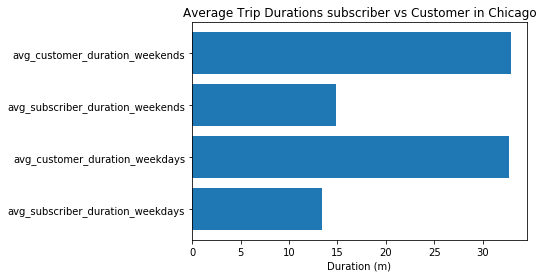

In [74]:

# chose the Chicago data file to do the visualization
city_file = './data/Chicago-2016-Summary.csv'


avg_subscriber_duration_weekdays,avg_customer_duration_weekdays,avg_subscriber_duration_weekends,avg_customer_duration_weekends = trip_duration_pattern(filename)
 
avg_duration_set = [avg_subscriber_duration_weekdays,avg_customer_duration_weekdays,avg_subscriber_duration_weekends,avg_customer_duration_weekends]
bar_set = ['avg_subscriber_duration_weekdays', 'avg_customer_duration_weekdays', 'avg_subscriber_duration_weekends', 'avg_customer_duration_weekends']

plt.barh(bar_set, avg_duration_set)
plt.title('Average Trip Durations subscriber vs Customer in Chicago')
plt.xlabel('Duration (m)')
plt.show()

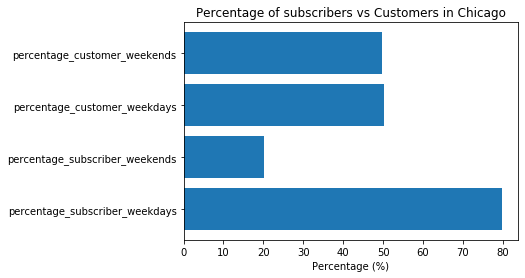

In [75]:

percent_n_subscriber_weekdays,percent_n_subscriber_weekends,percent_n_customer_weekdays,percent_n_customer_weekends = ridership_pattern(city_file)
                       
n_users_set = [percent_n_subscriber_weekdays * 100,percent_n_subscriber_weekends * 100,percent_n_customer_weekdays * 100,percent_n_customer_weekends * 100]
bar_set = ['percentage_subscriber_weekdays', 'percentage_subscriber_weekends', 'percentage_customer_weekdays', 'percentage_customer_weekends']

plt.barh(bar_set, n_users_set)
plt.title('Percentage of subscribers vs Customers in Chicago')
plt.xlabel('Percentage (%)')
plt.show()

<a id='conclusions'></a>
## Conclusions


According to the data analysis above, in all the three cities, 

- The bike-share service is used most in New York City. It has the highest number of trips among the three cities.
- The average trip duration is well under 30 minutes. and the percentage of trip duration over 30 minutes is from 7% to 11%. 
- Cusotmers takes longer rides on average. The average trip duration of subscribers is around 12 minutes, and the average trip duration of customers is over 30 minutes. 
- Most of subscribers take trip on weekdays and there is no much difference on their trip time on weekdays vs weekends. But the customers take similar trip numbers and similar times both on weekends and weekdays. 




In [76]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

0